Driver script to import and pre-process the OASIS brain data.
Builds and trains the VQVAE model, generating images and SSIM accuracy of the test dataset.

@author Mallika Mukherji
@email m.mukherji@uqconnect.edu.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from vqvae_model import *

In [2]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


In [3]:
# Initialise paths for training, testing and validation sets
TRAIN_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_train"
TEST_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_test"
VAL_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_validate"

In [4]:
# Incitialise directories for training, testing and validation data
train_files = os.listdir(TRAIN_IMAGE_PATH)
test_files = os.listdir(TEST_IMAGE_PATH)
validate_files = os.listdir(VAL_IMAGE_PATH)

In [5]:
# Initialise image dimensions for model
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
def load_images(path, image_files):
    """
    Returns a list of resized images at the given path.
    """
    images = []

    for file in image_files:
        image = Image.open(path + '/' + file) 
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image = np.reshape(image, (IMG_HEIGHT, IMG_WIDTH, 1))
        images.append(image)
        
    return images

In [7]:
# Load images into lists
train_images = load_images(TRAIN_IMAGE_PATH, train_files)
test_images = load_images(TEST_IMAGE_PATH, test_files)

In [8]:
# Convert lists into np arrays
x_train = np.array(train_images)
x_test = np.array(test_images)

In [9]:
# Pre-process the OASIS brain data.
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

# Calculate data variance
data_variance = np.var(x_train / 255.0)

# Check shapes of arrays
print(x_train.shape)
print(data_variance.shape)

(9664, 128, 128, 1)
()


In [10]:
# Display 
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Train Image', 'Test Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=plt.cm.gray)
        plt.axis('off')
    
    plt.show()

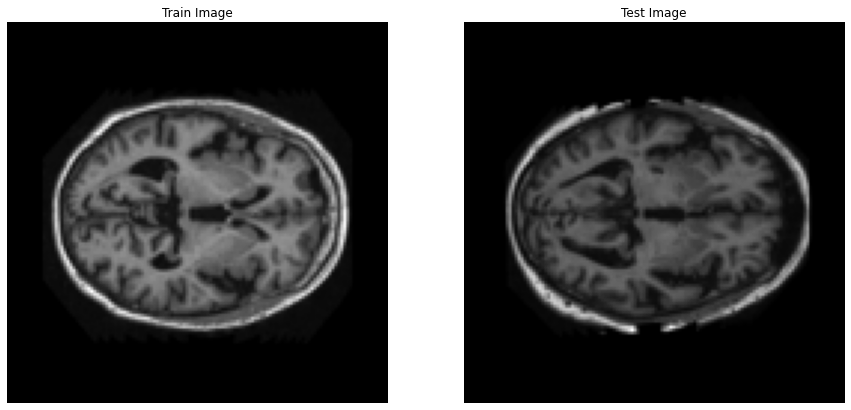

In [11]:
# Check dataset has been successfully loaded and pre-processed.
display([x_train_scaled[0], x_test_scaled[0]])

In [12]:
# Train the VQVAE model
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
76/76 [==============================] - 11s 69ms/step - loss: 3.5674 - reconstruction_loss: 1.5770 - vqvae_loss: 1.00662s - loss: 3.3850 - reconstruction_loss: 2.1016 - vqvae_loss: 0. - ETA: 2s - loss: 3.3403 - reconstruction_loss: 2.0528 - vq - ETA: 1s - loss: 3.202
Epoch 2/30
76/76 [==============================] - 5s 64ms/step - loss: 52.6861 - reconstruction_loss: 0.4697 - vqvae_loss: 52.0904
Epoch 3/30
76/76 [==============================] - 5s 64ms/step - loss: 3.0402 - reconstruction_loss: 0.3413 - vqvae_loss: 2.6946
Epoch 4/30
76/76 [==============================] - 5s 64ms/step - loss: 1.7045 - reconstruction_loss: 0.3201 - vqvae_loss: 1.3752 1s - loss: 1.7864 - 
Epoch 5/30
76/76 [==============================] - 5s 65ms/step - loss: 0.9208 - reconstruction_loss: 0.3079 - vqvae_loss: 0.6118 2s - loss: 0.9718 - reconstruction_loss: 0 - ETA: 1s - loss: 0.9
Epoch 6/30
76/76 [==============================] - 5s 65ms/step - loss: 0.7215 - reconstruction_loss: 0.270

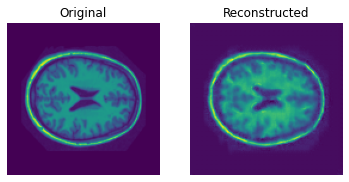

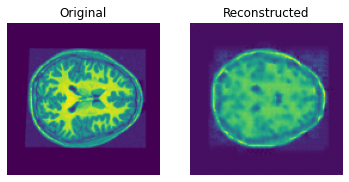

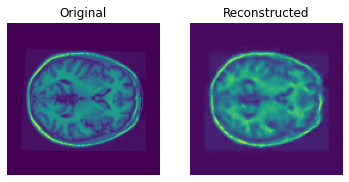

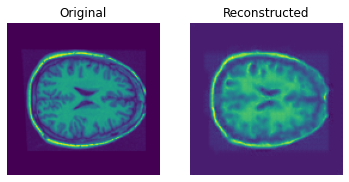

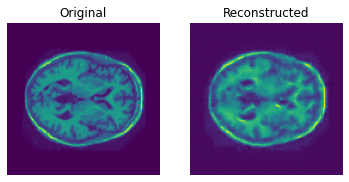

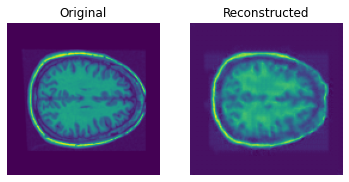

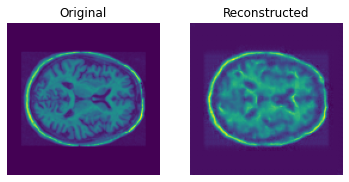

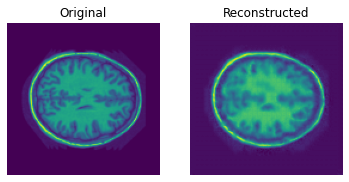

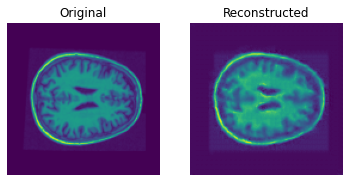

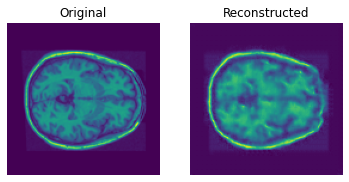

In [13]:
# Visualise reconstructions on the test set

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

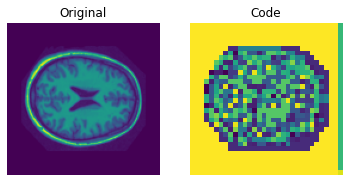

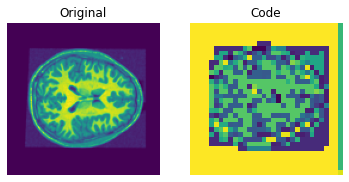

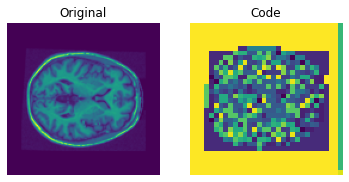

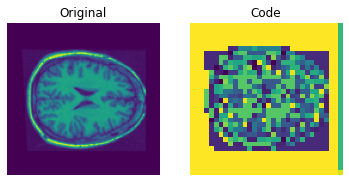

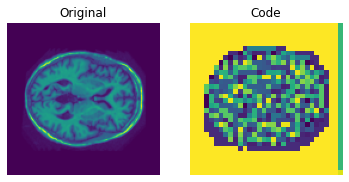

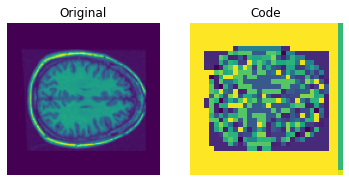

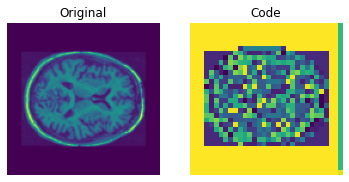

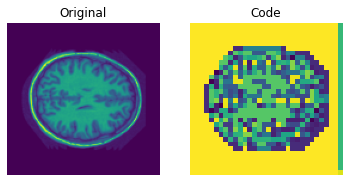

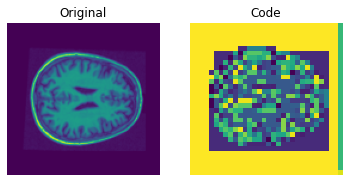

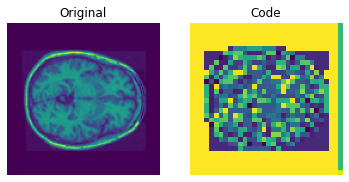

In [14]:
# Visualise the discrete codes

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()